In [45]:
import numpy as np
import pandas as pd

class Relation:
    def __init__(self, nodes, rel_pairs):
        self.nodes = nodes
        self.rel_pairs = rel_pairs

    def is_reflexive(self):
        reflexive = True
        for node in self.nodes:
            if (node, node) not in self.rel_pairs:
                reflexive = False
                break
        return reflexive

    def is_irreflexive(self):
        irreflexive = True
        for node in nodes:
            if (node, node) in self.rel_pairs:
                irreflexive = False
                break
        return irreflexive

    def is_symmetric(self):
        symmetric = True
        for (x, y) in self.rel_pairs:
            if (y, x) not in self.rel_pairs:
                symmetric = False
                break
        return symmetric

    def is_transitive(self):
        transitive = True
        for (x, y1) in self.rel_pairs:
            for (y2, z) in self.rel_pairs:
                if y1==y2 and (x, z) not in self.rel_pairs:
                    transitive = False
                    break
        return transitive

    def is_asymmetric(self):
        asymmetric = True
        for (x,y) in self.rel_pairs:
            if((y,x) in self.rel_pairs):
                asymmetric = False
                break
        return asymmetric

    def is_antisymmetric(self):
        antisymmetric = True
        for (x, y) in self.rel_pairs:
            if x != y and (y, x) in self.rel_pairs:
                antisymmetric = False
                break
        return antisymmetric

    def get_reflexive_pairs(self):
        reflexive_pairs = []
        for (x,y) in self.rel_pairs:
            if(x == y):
                reflexive_pairs.append((x,y))
        return reflexive_pairs

    def get_symmetric_pairs(self):
        symmetric_pairs = []
        for (x,y) in self.rel_pairs:
            if(x != y and (y,x) in self.rel_pairs):
                symmetric_pairs.append(((x,y), (y,x)))
        return symmetric_pairs

    def get_transitive_paths(self):
        transitive_paths = []
        for (x,y1) in self.rel_pairs:
            for (y2,z) in self.rel_pairs:
                if(y1==y2 and x != y1 and y2 != z and x!=z and (x,z) in self.rel_pairs):
                    transitive_paths.append(((x,y1), (y2,z), (x,z)))
        return transitive_paths
    
    def get_equivalence_classes(self):
        equivalence_classes = {}
        for (x,y) in self.rel_pairs:
            if(x not in equivalence_classes):
                equivalence_classes[x] = set()
            equivalence_classes[x].add(y)
        return equivalence_classes
    
    def get_relation_matrix(self):
        matrix = np.zeros((len(self.nodes), len(self.nodes)), dtype=int)
        index_map = {node: i for i, node in enumerate(self.nodes)}
        for (x, y) in self.rel_pairs:
            matrix[index_map[x], index_map[y]] = 1
        return matrix

    def is_equivalence(self):
        return self.is_reflexive() and self.is_symmetric() and self.is_transitive()

    def is_partial_order(self):
        return self.is_reflexive() and self.is_antisymmetric() and self.is_transitive()
    
class HasseDiagram:
    def __init__(self, relation: Relation):
        if(not relation.is_partial_order()):
            raise ValueError("Relation is not a partial order")
        self.relation = relation
        self.nodes = relation.nodes
        self.diagram = self._build_hasse_diagram()
        self.levels = self._compute_levels()
        
    def _build_hasse_diagram(self):
        filtered_pairs: list = []
        # filter reflexive pairs
        for p in self.relation.rel_pairs:
            if p[0] != p[1]:
                filtered_pairs.append(p)
        # filter transitive pairs
        for (x, y1) in filtered_pairs:
            for (y2, z) in filtered_pairs:
                if(y1==y2):
                    try:
                        transitive_pair_index = filtered_pairs.index((x, z))
                        filtered_pairs.pop(transitive_pair_index)
                    except ValueError:
                        pass
        return filtered_pairs

    def _compute_levels(self):
        min_elements = [n for n in self.nodes]
        for (x, y) in self.diagram:
            try:
                min_elements.remove(y)
            except ValueError:
                pass
        levels = {}
        for element in min_elements:
            levels[element] = 0
        self._find_levels(0, min_elements, levels)
        return levels
    
    def _find_levels(self, current_level: int, current_elements: list, levels: dict):
        for current_element in current_elements:
            if current_element not in levels:
                levels[current_element] = current_level
            elif levels[current_element] < current_level:
                levels[current_element] = current_level
            next_elements = [y for (x, y) in self.diagram if x == current_element]
            self._find_levels(current_level + 1, next_elements, levels)   

In [46]:
# Print hasse diagram
import matplotlib.pyplot as plt
import networkx as nx

def plot_hasse_diagram(relation: Relation):
    hasse_diagram = HasseDiagram(relation)
    g = nx.DiGraph()
    for node in hasse_diagram.nodes:
        g.add_node(node, level=hasse_diagram.levels[node])
    g.add_edges_from(hasse_diagram.diagram)
    
    pos = nx.multipartite_layout(g, subset_key='level', align='horizontal')
    nx.draw(g, pos=pos, with_labels=True)
    plt.show()
    
def plot_graph(relation: Relation):
    g = nx.DiGraph()
    for node in relation.nodes:
        g.add_node(node)
    g.add_edges_from(relation.rel_pairs)
    nx.draw(g, with_labels=True)
    plt.show()

def show_properties(relation: Relation, name: str):
    print('||||||||||||||||||||||||||||||||')
    print('------ ', name, ' ------')
    plot_graph(relation)
    print('- Relation pairs: ', relation.rel_pairs)
    reflexive = relation.is_reflexive()
    print('- Is reflexive: ', reflexive)
    if reflexive:
        print('    - Pairs: ', relation.get_reflexive_pairs())
    symmetric = relation.is_symmetric()
    print('- Is symmetric: ', symmetric)
    if symmetric:
        print('    - Pairs: ', relation.get_symmetric_pairs())
    transitive = relation.is_transitive()
    print('- Is transitive: ', transitive)
    if transitive:
        print('    - Paths: ', relation.get_transitive_paths())
    print('- Is asymmetric: ', relation.is_asymmetric())
    print('- Is antisymmetric: ', relation.is_antisymmetric())
    df = pd.DataFrame(relation.get_relation_matrix(), index=relation.nodes, columns=relation.nodes)
    print('\nRelation matrix:')
    display(df)
    if relation.is_equivalence():
        print('- Equivalence: ', True)
        print('    - Classes: ', relation.get_equivalence_classes())
    elif relation.is_partial_order():
        print('- Partial order: ', True)
        hasse_diagram = HasseDiagram(relation)
        print('- Hasse diagram: ', hasse_diagram.diagram)
        plot_hasse_diagram(relation)
    print('||||||||||||||||||||||||||||||||')

In [47]:
# Symetric
relation_a = Relation([1, 2, 3], [(1, 2), (2, 1), (3, 3)])
print('A: ', relation_a.rel_pairs, 'is symmetric: ', relation_a.is_symmetric())

# Asymmetric
relation_b = Relation([1, 2, 3, 4], [(1, 2), (2, 3), (3, 4)])
print('B: ', relation_b.rel_pairs, 'is asymmetric: ', relation_b.is_asymmetric())

# Antisymmetric
relation_c = Relation([1, 2, 3, 4], [(1, 1), (2, 2), (1, 2), (3, 4)])
print('C: ', relation_c.rel_pairs, 'is antisymmetric: ', relation_c.is_antisymmetric())

# Transitive
relation_d = Relation([1, 2, 3, 4], [(1, 2), (2, 3), (1, 3), (3, 4), (2, 4), (1, 4)])
print('D: ', relation_d.rel_pairs, 'is transitive: ', relation_d.is_transitive())

A:  [(1, 2), (2, 1), (3, 3)] is symmetric:  True
B:  [(1, 2), (2, 3), (3, 4)] is asymmetric:  True
C:  [(1, 1), (2, 2), (1, 2), (3, 4)] is antisymmetric:  True
D:  [(1, 2), (2, 3), (1, 3), (3, 4), (2, 4), (1, 4)] is transitive:  True


In [48]:
# Equivalence
relation_e = Relation([1, 2, 3, 4, 5], [(1, 1), (2, 2), (3, 3), (1, 2), (2, 1), (4, 4), (5, 5), (4, 5), (5, 4)])

# Partial order
relation_f = Relation([1, 2, 3, 4, 5], [(1, 1), (2, 2), (3, 3),(1, 2), (2, 3), (1, 3), (1, 4), (1, 5), (4, 5), (4, 4), (5, 5), (5, 3), (4, 3)])

# Partial order
relation_g = Relation([2, 4, 5, 10, 12, 20, 25], [
    (2, 2), (2, 4), (2, 10), (2, 12), (2, 20),
    (4, 4), (4, 12), (4, 20),
    (5, 5), (5, 10), (5, 20), (5, 25),
    (10, 10), (10, 20),
    (12, 12),
    (20, 20),
    (25, 25)
])

||||||||||||||||||||||||||||||||
------  E  ------


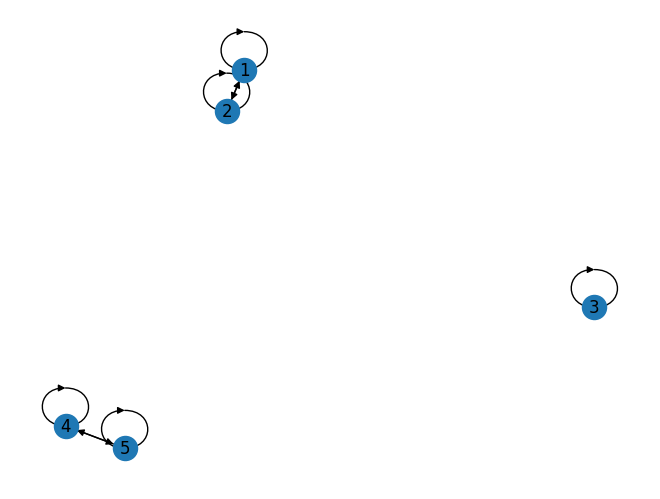

- Relation pairs:  [(1, 1), (2, 2), (3, 3), (1, 2), (2, 1), (4, 4), (5, 5), (4, 5), (5, 4)]
- Is reflexive:  True
    - Pairs:  [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
- Is symmetric:  True
    - Pairs:  [((1, 2), (2, 1)), ((2, 1), (1, 2)), ((4, 5), (5, 4)), ((5, 4), (4, 5))]
- Is transitive:  True
    - Paths:  []
- Is asymmetric:  False
- Is antisymmetric:  False

Relation matrix:


,1,2,3,4,5
1,1,1,0,0,0
2,1,1,0,0,0
3,0,0,1,0,0
4,0,0,0,1,1
5,0,0,0,1,1


- Equivalence:  True
    - Classes:  {1: {1, 2}, 2: {1, 2}, 3: {3}, 4: {4, 5}, 5: {4, 5}}
||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||
------  F  ------


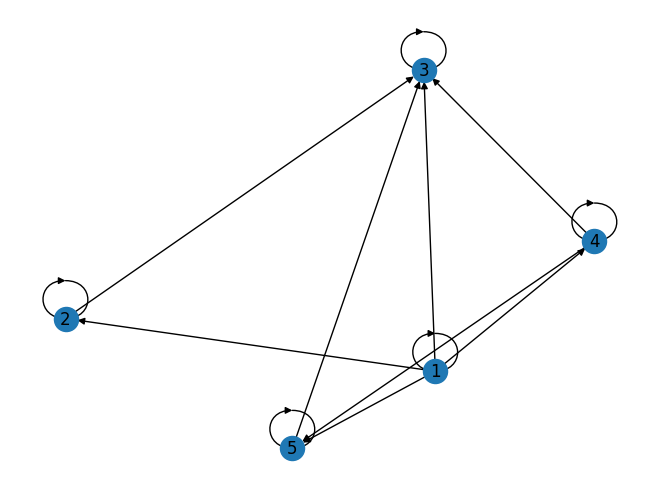

- Relation pairs:  [(1, 1), (2, 2), (3, 3), (1, 2), (2, 3), (1, 3), (1, 4), (1, 5), (4, 5), (4, 4), (5, 5), (5, 3), (4, 3)]
- Is reflexive:  True
    - Pairs:  [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]
- Is symmetric:  False
- Is transitive:  True
    - Paths:  [((1, 2), (2, 3), (1, 3)), ((1, 4), (4, 5), (1, 5)), ((1, 4), (4, 3), (1, 3)), ((1, 5), (5, 3), (1, 3)), ((4, 5), (5, 3), (4, 3))]
- Is asymmetric:  False
- Is antisymmetric:  True

Relation matrix:


,1,2,3,4,5
1,1,1,1,1,1
2,0,1,1,0,0
3,0,0,1,0,0
4,0,0,1,1,1
5,0,0,1,0,1


- Partial order:  True
- Hasse diagram:  [(1, 2), (2, 3), (1, 4), (4, 5), (5, 3)]


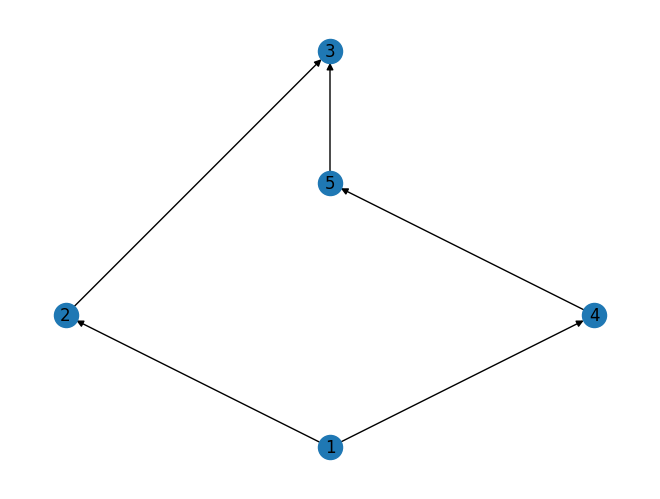

||||||||||||||||||||||||||||||||
||||||||||||||||||||||||||||||||
------  G  ------


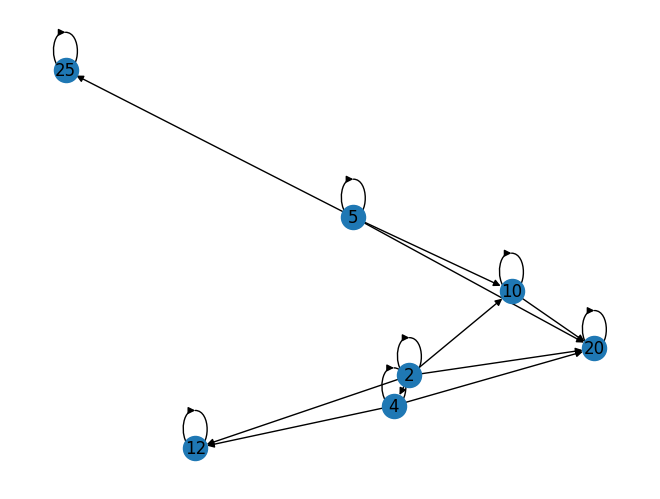

- Relation pairs:  [(2, 2), (2, 4), (2, 10), (2, 12), (2, 20), (4, 4), (4, 12), (4, 20), (5, 5), (5, 10), (5, 20), (5, 25), (10, 10), (10, 20), (12, 12), (20, 20), (25, 25)]
- Is reflexive:  True
    - Pairs:  [(2, 2), (4, 4), (5, 5), (10, 10), (12, 12), (20, 20), (25, 25)]
- Is symmetric:  False
- Is transitive:  True
    - Paths:  [((2, 4), (4, 12), (2, 12)), ((2, 4), (4, 20), (2, 20)), ((2, 10), (10, 20), (2, 20)), ((5, 10), (10, 20), (5, 20))]
- Is asymmetric:  False
- Is antisymmetric:  True

Relation matrix:


,2,4,5,10,12,20,25
2,1,1,0,1,1,1,0
4,0,1,0,0,1,1,0
5,0,0,1,1,0,1,1
10,0,0,0,1,0,1,0
12,0,0,0,0,1,0,0
20,0,0,0,0,0,1,0
25,0,0,0,0,0,0,1


- Partial order:  True
- Hasse diagram:  [(2, 4), (2, 10), (4, 12), (4, 20), (5, 10), (5, 25), (10, 20)]


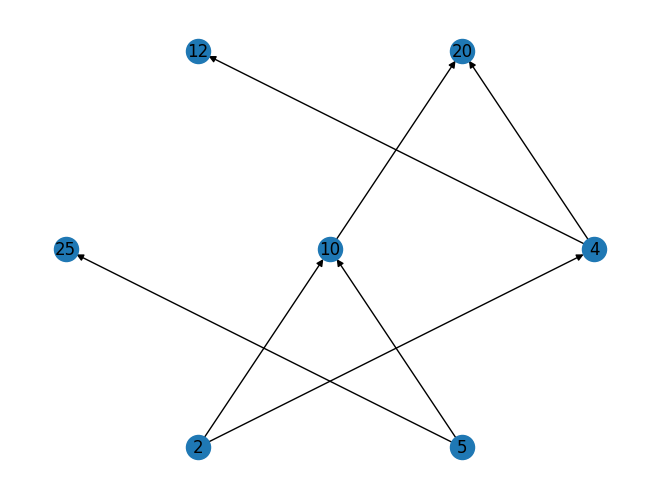

||||||||||||||||||||||||||||||||


In [49]:
show_properties(relation_e, 'E')
show_properties(relation_f, 'F')
show_properties(relation_g, 'G')